In [1]:
from imp import reload
import os
import glob

import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# load a test image
test_img_file = './test_images/test6.jpg'
test_img = mpimg.imread(test_img_file)

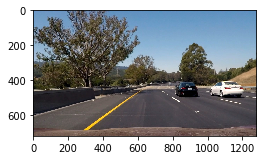

In [3]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(4, 3))
ax1.imshow(test_img)
plt.show()

### Draw Sliding Windows
- The Red rectangle in each image below is the final window. 

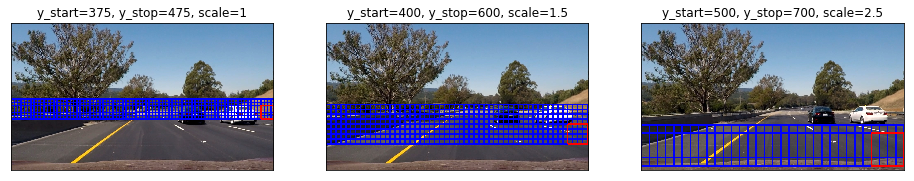

In [33]:
from utils.draw_functions import draw_sliding_windows

ystart_ystop_scale_list = [
    (375, 475, 1), 
    (400, 600, 1.5), 
    (500, 700, 2.5)
]

plt.figure(figsize=(16, 18))
for n_subplot, (y_start, y_stop, scale) in enumerate(ystart_ystop_scale_list, start=1):
    plt.subplot(1, 3, n_subplot)
    plt.imshow(draw_sliding_windows(test_img, y_start, y_stop, scale))
    plt.title('y_start={}, y_stop={}, scale={}'.format(str(y_start), str(y_stop), str(scale)))
    plt.xticks([])
    plt.yticks([])
plt.show()

### Load the trained model and scaler

In [7]:
from sklearn.externals import joblib

scaler = joblib.load('./model_training/standard_scaler.pkl')
clf = joblib.load('./model_training/linear_svm.pkl')

### Vehicle Detection

In [15]:
# common settings
orient = 9
color_space = 'YCrCb'
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
bin_spatial_size = (32, 32)
n_hist_bins = 32

#### Try different scales, y_start and y_stop

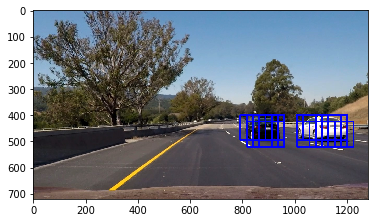

In [32]:
reload(draw_functions)
reload(feature_extraction)
from utils.draw_functions import draw_boxes
from utils import feature_extraction

ystart = 400
ystop = 600
scale = 1.5
   
bbox_list = feature_extraction.find_cars(
    test_img, 
    ystart, ystop, scale, 
    clf, scaler, 
    color_space, orient, pix_per_cell, cell_per_block, hog_channel, 
    bin_spatial_size, 
    n_hist_bins)
img_detected = draw_boxes(test_img, bbox_list)
plt.imshow(img_detected)
plt.show()

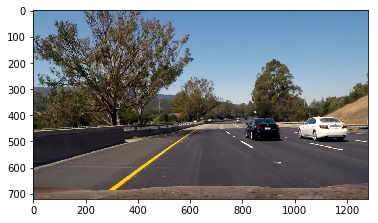

In [30]:
reload(draw_functions)
reload(feature_extraction)
from utils.draw_functions import draw_boxes
from utils import feature_extraction

ystart = 375
ystop = 475
scale = 1
   
bbox_list = feature_extraction.find_cars(
    test_img, 
    ystart, ystop, scale, 
    clf, scaler, 
    color_space, orient, pix_per_cell, cell_per_block, hog_channel, 
    bin_spatial_size, 
    n_hist_bins)
img_detected = draw_boxes(test_img, bbox_list)
plt.imshow(img_detected)
plt.show()

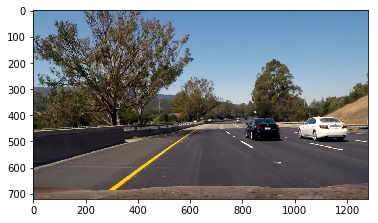

In [31]:
reload(draw_functions)
reload(feature_extraction)
from utils.draw_functions import draw_boxes
from utils import feature_extraction

ystart = 500
ystop = 700
scale = 2.5
   
bbox_list = feature_extraction.find_cars(
    test_img, 
    ystart, ystop, scale, 
    clf, scaler, 
    color_space, orient, pix_per_cell, cell_per_block, hog_channel, 
    bin_spatial_size, 
    n_hist_bins)
img_detected = draw_boxes(test_img, bbox_list)
plt.imshow(img_detected)
plt.show()

#### Try different y_start, y_stop and scale simultaneouly

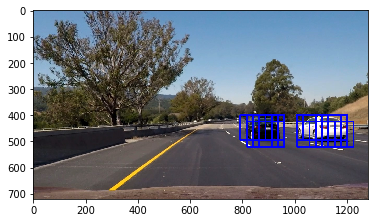

In [38]:
bbox_list = []
for (ystart, ystop, scale) in ystart_ystop_scale_list:
    bbox_list.extend(
        feature_extraction.find_cars(
            test_img, 
            ystart, ystop, scale, 
            clf, scaler, 
            color_space, orient, pix_per_cell, cell_per_block, hog_channel, 
            bin_spatial_size, 
            n_hist_bins)
    )
img_detected = draw_boxes(test_img, bbox_list)
plt.imshow(img_detected)
plt.show()

### Heatmap

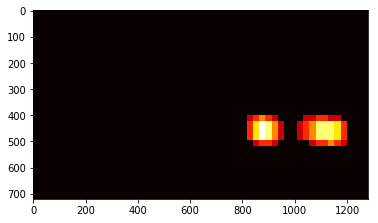

In [44]:
from utils.vehicle_detection import get_thresholded_heatmap

heatmap = np.zeros_like(test_img[:, :, 0]).astype(np.float)
heatmap = get_thresholded_heatmap(heatmap, bbox_list)
plt.imshow(heatmap, cmap='hot')
plt.show()

### Labeled

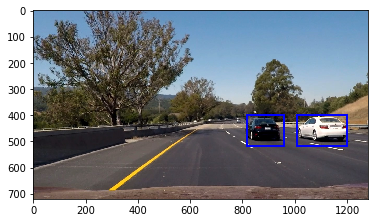

In [53]:
reload(utils.vehicle_detection)
from scipy.ndimage.measurements import label

from utils.vehicle_detection import get_labeled_bboxes


labels = label(heatmap)
bbox_list = get_labeled_bboxes(test_img, labels)
img_detected = draw_boxes(test_img, bbox_list)
plt.imshow(img_detected)
plt.show()

### Pipeline

In [54]:
from scipy.ndimage.measurements import label

from utils.feature_extraction import find_cars
from utils.vehicle_detection import get_thresholded_heatmap
from utils.vehicle_detection import get_labeled_bboxes

ystart_ystop_scale_list = [
    (375, 475, 1), 
    (400, 600, 1.5), 
    (500, 700, 2.5)
]

def pipeline(img):
    # Sliding window search
    bbox_list = []
    for (ystart, ystop, scale) in ystart_ystop_scale_list:
        bbox_list.extend(
            find_cars(
                img, 
                ystart, ystop, scale, 
                clf, scaler, 
                color_space, orient, pix_per_cell, cell_per_block, hog_channel, 
                bin_spatial_size, 
                n_hist_bins)
        )
    # Heatmap
    heatmap = np.zeros_like(img[:, :, 0]).astype(np.float)
    heatmap = get_thresholded_heatmap(heatmap, bbox_list)
    # Labeled bbox
    labels = label(heatmap)
    bbox_list = get_labeled_bboxes(img, labels)
    img_detected = draw_boxes(img, bbox_list)

    return img_detected

#### Pipeline test for images

In [55]:
img_files = glob.glob(os.path.join('test_images', '*.jpg'))
imgs = []
for img_file in img_files:
    img = cv2.cvtColor(cv2.imread(img_file), cv2.COLOR_BGR2RGB)
    imgs.append(img)

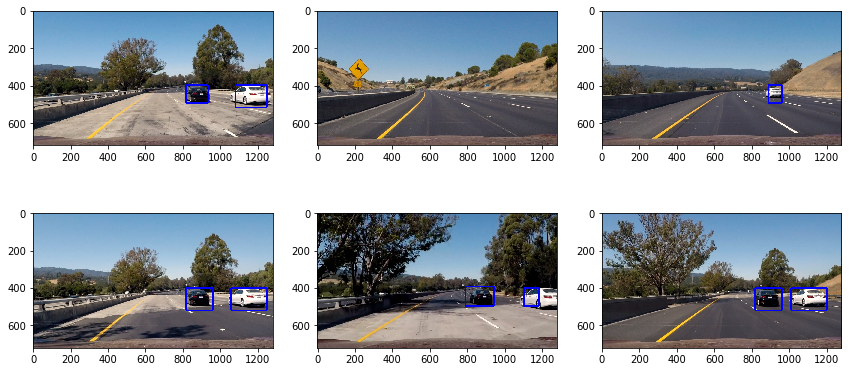

In [56]:
# Cars detected
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
axes[0][0].imshow(pipeline(imgs[0]))
axes[0][1].imshow(pipeline(imgs[1]))
axes[0][2].imshow(pipeline(imgs[2]))
axes[1][0].imshow(pipeline(imgs[3]))
axes[1][1].imshow(pipeline(imgs[4]))
axes[1][2].imshow(pipeline(imgs[5]))
plt.tight_layout()
plt.savefig(os.path.join('output_images', 'vehicle_detection.jpg'))
plt.show()

#### Pipeline test for videos

In [57]:
# Video test
from IPython.display import HTML
from moviepy.editor import VideoFileClip

output = 'test_video_output.mp4'
clip1 = VideoFileClip("test_video.mp4")
clip = clip1.fl_image(pipeline)
%time clip.write_videofile(output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [00:20<00:00,  1.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 19.1 s, sys: 1.22 s, total: 20.3 s
Wall time: 22.6 s


### Video Implementation

In [59]:
from IPython.display import HTML
from moviepy.editor import VideoFileClip


output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(pipeline)
%time clip.write_videofile(output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [10:58<00:00,  2.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 10min, sys: 38.3 s, total: 10min 38s
Wall time: 10min 59s
